# NFL Final Project

### Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
%matplotlib inline

from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 

import seaborn as sb

### Wrangle Data

In [5]:
# set variables
data = pd.read_csv("nfl-data/scores.csv")
teams = pd.read_csv("nfl-data/teams.csv")

# clean empty cells
data = data.replace(r'^\s*$', np.nan, regex=True)
# select data with over/under and spread
data = data[(data.over_under_line.isnull() == False) & (data.spread_favorite.isnull() == False)]
data.reset_index(drop=True, inplace=True)
#convert data type
data['over_under_line'] = data.over_under_line.astype(float)
# reference team id
data['team_home'] = data.team_home.map(teams.set_index('team_name')['team_id'].to_dict())
data['team_away'] = data.team_away.map(teams.set_index('team_name')['team_id'].to_dict())
# drop columns 
data = data[['schedule_date', 'schedule_season', 'schedule_week', 'team_home',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'score_home', 'score_away',
       'stadium_neutral']]
#home and away favorites
data['home_fav'] = (data.team_home == data.team_favorite_id).astype(int)
data['away_fav'] = (data.team_away == data.team_favorite_id).astype(int)
#final result array
data['result'] = (data.score_home > data.score_away).astype(int)

### Explore Data

In [3]:
data[50:60]

NameError: name 'data' is not defined

In [4]:
data.shape

(9860, 14)

In [5]:
data.describe().round(2)

,schedule_season,spread_favorite,over_under_line,score_home,score_away,home_fav,away_fav,result
count,9860.00,9860.00,9860.00,9860.00,9860.00,9860.00,9860.00,9860.00
mean,1999.46,-5.37,41.84,22.64,19.83,0.67,0.32,0.58
std,11.41,3.42,4.67,10.40,10.03,0.47,0.46,0.49
min,1967.00,-26.50,28.00,0.00,0.00,0.00,0.00,0.00
25%,1990.00,-7.00,38.00,16.00,13.00,0.00,0.00,0.00
50%,2000.00,-4.50,41.50,22.00,20.00,1.00,0.00,1.00
75%,2009.00,-3.00,45.00,30.00,27.00,1.00,1.00,1.00
max,2018.00,0.00,63.50,62.00,59.00,1.00,1.00,1.00


In [6]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,schedule_season,spread_favorite,over_under_line,score_home,score_away,stadium_neutral,home_fav,away_fav,result
schedule_season,1,-0.021,0.33,0.063,0.085,0.012,-0.0088,0.026,-0.0065
spread_favorite,-0.021,1,-0.059,-0.15,0.12,-0.014,-0.23,0.18,-0.15
over_under_line,0.33,-0.059,1,0.21,0.2,0.05,0.0059,0.0016,0.005
score_home,0.063,-0.15,0.21,1,-0.023,0.0012,0.22,-0.22,0.55
score_away,0.085,0.12,0.2,-0.023,1,0.023,-0.23,0.23,-0.57
stadium_neutral,0.012,-0.014,0.05,0.0012,0.023,1,-0.021,0.024,-0.02
home_fav,-0.0088,-0.23,0.0059,0.22,-0.23,-0.021,1,-0.97,0.28
away_fav,0.026,0.18,0.0016,-0.22,0.23,0.024,-0.97,1,-0.28
result,-0.0065,-0.15,0.005,0.55,-0.57,-0.02,0.28,-0.28,1


In [7]:
win_percentage = round(sum(data.result)/len(data.result),2)
fav_percentage = sum(((data.home_fav == 1) & (data.result == 1)) | ((data.away_fav == 1) & (data.result == 0))) / len(data.result)

print("Home win  = %{}".format(round(win_percentage*100, 2)))
print("Away win percentage = %{}".format(round((1 - win_percentage)*100, 2)))
print("Favored win percentage = %{}".format(round((fav_percentage)*100, 2)))

Home win percentage = %58.0
Away win percentage = %42.0
Favored win percentage = %65.16


### Machine Learning

In [8]:
X = data[['over_under_line','spread_favorite','home_fav']]
y = data['result']
results=[]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)
classifier = DecisionTreeClassifier(min_samples_split=2, max_depth=5)

kfold = model_selection.KFold(n_splits=5, random_state=0)
cv_results = model_selection.cross_val_score(classifier, X, y, cv=kfold, scoring = 'roc_auc')
results.append(cv_results)

msg = "%f (%f)" % (cv_results.mean(), cv_results.std())

print(msg)
classifier.fit(X_train,y_train)
y_predict = classifier.predict(X_test)

print(accuracy_score(y_test, y_predict))

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Loss', 'Predicted Win'],
    index=['True Loss', 'True Win']
)

0.688036 (0.013721)
0.6369168356997972


,Predicted Loss,Predicted Win
True Loss,400,413
True Win,303,856


## ML Model

In [9]:
X = data[['over_under_line','spread_favorite','home_fav']]
y = data[['result']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=1)

gnb = GaussianNB()
dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
lrg = LogisticRegression(solver='liblinear')
vote = VotingClassifier(estimators=[('dtc', dtc), ('lrg', lrg)], voting='soft')

model = CCV(vote, method='isotonic', cv=3)
model.fit(X_train, y_train)

predicted = model.predict_proba(X_test)[:,1]

# ROC AUC Score and Brier Score
print("Metrics" + "\t\t" + "My Model")
print("ROC AUC Score: " +  "\t" + "{:.4f}".format(roc_auc_score(y_test, predicted)))
print("Brier Score: " + "\t" + "{:.4f}".format(brier_score_loss(y_test, predicted)))
print(predicted)


/home/liam/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Metrics		My Model
ROC AUC Score: 	0.6914
Brier Score: 	0.2164
[0.71931861 0.67301296 0.60627967 ... 0.85841993 0.79370224 0.43980672]


In [10]:
test = X_test.copy()
test.loc[:,'hm_prob'] = predicted
test.loc[:, 'result'] = y

test['my_bet_won'] = (((test.hm_prob >= 0.55) & (y.result == 1)) | ((test.hm_prob <= 0.40) & (test.result == 0))).astype(int)
test['my_bet_lost'] = (((test.hm_prob >= 0.55) & (y.result == 0)) | ((test.hm_prob <= 0.40) & (test.result == 1))).astype(int)

print("Model Win Percentage: " + "{:.4f}".format(test.my_bet_won.sum() / (test.my_bet_lost.sum() + test.my_bet_won.sum())))

print("Total Number of Bets Won: " + str(test.my_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Possible Games: " + str(len(test)))


Model Win Percentage: 0.6924
Total Number of Bets Won: 1067
Total Number of Bets Made: 1541
Possible Games: 1972


In [81]:
# set params
nn = Sequential()
nn.add(Dense(100, activation='relu', kernel_initializer='random_normal', input_dim=3))
nn.add(Dense(100, activation='relu', kernel_initializer='random_normal'))
nn.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
# train model
history = nn.fit(X_train, y_train, batch_size=10, epochs=10)

Train on 7888 samples
Epoch 1/10
7888/7888 [==============================] - 8s 968us/sample - loss: 0.6599 - acc: 0.5944
Epoch 2/10
7888/7888 [==============================] - 6s 775us/sample - loss: 0.6359 - acc: 0.6485
Epoch 3/10
7888/7888 [==============================] - 6s 700us/sample - loss: 0.6281 - acc: 0.6557
Epoch 4/10
7888/7888 [==============================] - 5s 605us/sample - loss: 0.6250 - acc: 0.6578
Epoch 5/10
7888/7888 [==============================] - 5s 619us/sample - loss: 0.6229 - acc: 0.6572
Epoch 6/10
7888/7888 [==============================] - 7s 901us/sample - loss: 0.6219 - acc: 0.6556
Epoch 7/10
7888/7888 [==============================] - 6s 703us/sample - loss: 0.6229 - acc: 0.6587
Epoch 8/10
7888/7888 [==============================] - 5s 638us/sample - loss: 0.6221 - acc: 0.6590s - l
Epoch 9/10
7888/7888 [==============================] - 5s 599us/sample - loss: 0.6217 - acc: 0.6583
Epoch 10/10
7888/7888 [==============================] - 5s 586u

In [83]:
nnEval = nn.evaluate(X_train, y_train)

7888/7888 [==============================] - 1s 174us/sample - loss: 0.6184 - acc: 0.6594


Text(0, 0.5, 'Loss')

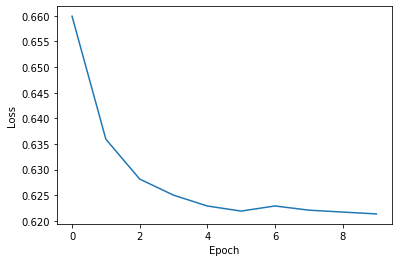

In [84]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [54]:
y_pred = nn.predict(X_test)
y_pred = (y_pred>0.5)
y_pred

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

[Text(0, 0.5, 'away'), Text(0, 1.5, 'home')]

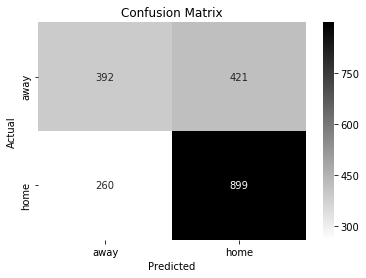

In [55]:
values = [0, 1]
labels = ['away', 'home']
cm = confusion_matrix(y_test, y_pred, values)
ax = plt.subplot()
sb.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='binary')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)